In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from io import StringIO
import matplotlib.pyplot as plt

## Get tariff details

Set the STUFE and GRUPPE variables accordingly. PERCENT is the percentage of a full contract you have (e.g. 75% for a PhD contract)
If you work part time, set CURRENT_HOURS to the number of hours you work per week (to the nearest multiple of 2)

In [2]:
GRUPPE = 13
STUFE = 4
PERCENT = 1
CURRENT_HOURS = 32

In [3]:


res = []
# 
for z in np.arange(105,step=5):
    if z == 0:
        res.append({'arbeitszeit':0, 'stunden': 0, 'brutto': 0, 'netto': 0})
        continue
    url = f'https://oeffentlicher-dienst.info/c/t/rechner/tv-l/allg?id=tv-l-2025&g=E_{GRUPPE}&s={STUFE}&zv=VBL&z={z}&zulage=&stj=2024&stkl=4&r=0&zkf=0&pvk=0&kk=15.5'
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    #t = soup.select('div.scroll-table')[0].select('table')[0]
    t = soup.select('table')[1]
    df = pd.read_html(StringIO(t.decode()))[0]
    df = df.rename(columns={ df.columns[0]: "index" }).set_index('index')
    vals = [x.replace('\xa0€','') for x in df['4'].values]
    res.append({
        'arbeitszeit': z,
        'stunden': 40/100*z,
        'brutto': vals[0],
        'netto': vals[2]
    })
    
df = pd.DataFrame.from_dict(res)
df['brutto'] = df['brutto'].astype(float)
df['netto'] = df['netto'].astype(float)

df['arbeitszeit'] = df['arbeitszeit']/PERCENT
df['stunden'] = df['stunden']/PERCENT
df = df[df['stunden']<=40]
df.head()

,arbeitszeit,stunden,brutto,netto
0,0.0,0.0,0.00,0.00
1,5.0,2.0,285.68,221.52
2,10.0,4.0,571.36,443.03
3,15.0,6.0,857.04,662.87
4,20.0,8.0,1142.72,882.91


Text(0, 0.5, 'Remuneration')

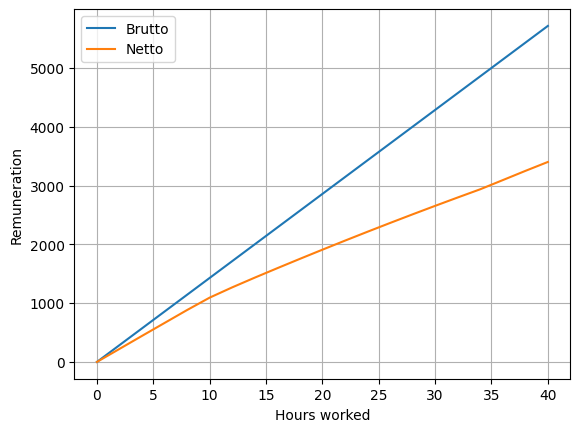

In [4]:
fig, ax = plt.subplots()
ax.plot(df['stunden'], df['brutto'], label='Brutto')
ax.plot(df['stunden'], df['netto'], label='Netto')
ax.grid()
ax.legend()
ax.set_xlabel('Hours worked')
ax.set_ylabel('Remuneration')

In [5]:
df

,arbeitszeit,stunden,brutto,netto
0,0.0,0.0,0.00,0.00
1,5.0,2.0,285.68,221.52
2,10.0,4.0,571.36,443.03
3,15.0,6.0,857.04,662.87
4,20.0,8.0,1142.72,882.91
5,25.0,10.0,1428.40,1093.45
6,30.0,12.0,1714.07,1267.99
7,35.0,14.0,1999.75,1433.27
8,40.0,16.0,2285.43,1593.95
9,45.0,18.0,2571.11,1752.40


In [6]:
max_netto = df[df['stunden']==CURRENT_HOURS]['netto'].values[0]
print(max_netto)

df['verlust'] = min(2770,max_netto) - df['netto']
df['egp'] = df['verlust'] * 0.65
df.loc[df['egp']<150,'egp'] = 150
df.loc[df['egp']>900,'egp'] = 900
df['kindergeld'] = 250
df.loc[df['verlust']<0,'egp'] = 0
df.loc[df['stunden']>32,'egp'] = 0
#df['total'] = 
df.tail()

2796.01


,arbeitszeit,stunden,brutto,netto,verlust,egp,kindergeld
16,80.0,32.0,4570.86,2796.01,-26.01,0.0,250
17,85.0,34.0,4856.54,2935.79,-165.79,0.0,250
18,90.0,36.0,5142.22,3091.49,-321.49,0.0,250
19,95.0,38.0,5427.90,3247.98,-477.98,0.0,250
20,100.0,40.0,5713.58,3400.29,-630.29,0.0,250


Text(0, 0.5, 'Net income')

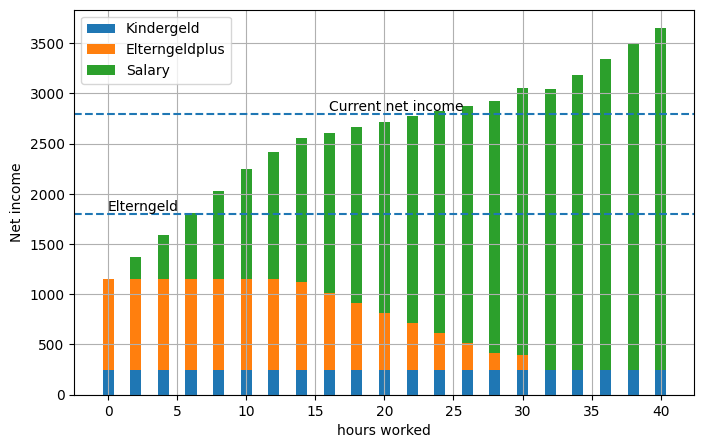

In [7]:
fig, ax = plt.subplots(figsize=(8,5))

eg = min(2770, max_netto)*0.65

ax.bar(df['stunden'], df['kindergeld'], label='Kindergeld')

ax.bar(df['stunden'], df['egp'], bottom=df['kindergeld'], label='Elterngeldplus')

ax.bar(df['stunden'], df['netto'], bottom=df['egp']+df['kindergeld'], label='Salary')
ax.text(0,eg, 'Elterngeld', va='bottom')
ax.axhline(max_netto, ls='--')
ax.text(16,max_netto, 'Current net income', va='bottom')
ax.axhline(eg, ls='--')
ax.grid()
ax.legend()
ax.set_xlabel('hours worked')
ax.set_ylabel('Net income')

In [8]:
df

,arbeitszeit,stunden,brutto,netto,verlust,egp,kindergeld
0,0.0,0.0,0.00,0.00,2770.00,900.0000,250
1,5.0,2.0,285.68,221.52,2548.48,900.0000,250
2,10.0,4.0,571.36,443.03,2326.97,900.0000,250
3,15.0,6.0,857.04,662.87,2107.13,900.0000,250
4,20.0,8.0,1142.72,882.91,1887.09,900.0000,250
5,25.0,10.0,1428.40,1093.45,1676.55,900.0000,250
6,30.0,12.0,1714.07,1267.99,1502.01,900.0000,250
7,35.0,14.0,1999.75,1433.27,1336.73,868.8745,250
8,40.0,16.0,2285.43,1593.95,1176.05,764.4325,250
9,45.0,18.0,2571.11,1752.40,1017.60,661.4400,250
